#### Julie Huang, Feb 10th, 2022
#### General analysis and visualization to understand features
#### 1. Use scaled and normalized PCA to plot responder vs non-responder group
#### 2. Generate feature importance based on tree methods
#### 3. Calculate and visualize pairwise correlation of features, guide feature selection
#### 4. For categorical features, make crosstab table, and perform Fisher's Exact test for 2X2 tables
#### 5. For continous features, make boxplot, calculate ranked sum statistics between response groups (use nonparamtric test here)

## Initialization

In [1]:
import numpy as np
import pandas as pd

import scipy as sp
from scipy import stats
from scipy.stats import fisher_exact
from scipy.stats import ranksums

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
from sklearn import metrics
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import scale, normalize
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

## Import dataset

In [2]:
df = pd.read_csv('data/dataset_clean.csv')

In [3]:
df.head()

,CTR1,Treatment_Flag,SEXN,MADCAM1,RDW_base,STOOLFN,PLATE_base,LDH_base,CREATN_base,BEMCS,BMCS,TPROT_base,BFECAL,BCRP,synthetic_probability,synthetic_target
0,4.545822,1,2,35.191478,13.039093,1,260,361,78,2,7,76,179.346304,3.171967,0.989748,1
1,0.000000,0,1,31.788908,14.958217,1,379,209,52,3,6,75,551.386183,5.435250,0.147631,0
2,0.000000,0,2,24.489860,14.139639,2,212,161,71,3,8,74,8877.368737,3.022854,0.047950,0
3,4.447084,1,2,24.386446,13.654885,1,228,156,88,3,8,72,1556.656010,3.413336,0.903484,1
4,0.000000,0,2,20.007027,14.247521,3,530,136,89,3,9,74,10887.520430,18.111985,0.013011,0


In [4]:
df.columns

Index(['CTR1', 'Treatment_Flag', 'SEXN', 'MADCAM1', 'RDW_base', 'STOOLFN',
       'PLATE_base', 'LDH_base', 'CREATN_base', 'BEMCS', 'BMCS', 'TPROT_base',
       'BFECAL', 'BCRP', 'synthetic_probability', 'synthetic_target'],
      dtype='object')

### PCA template for top features

In [5]:
features = ['SEXN', 'MADCAM1', 'RDW_base', 'STOOLFN','PLATE_base', 'LDH_base', 'CREATN_base', 'BEMCS', 'BMCS', 'TPROT_base', \
    'BFECAL', 'BCRP']
y_cat = ['Treatment_Flag']
y_cont = ['CTR1']

### Scale the data for PCA

In [6]:
def plot_pca_2_components_normalize_scale(df, features, y_cat):
    '''
    Input: df:dataframe, features: feature col names as a list, y_cat: col containing treatment flag
    '''
    pca = PCA(n_components=2)
    # without scaling
    #principalComponents = pca.fit_transform(df[features])
    
    # normalize and scale
    Xn = normalize(df[features])
    XsXn = scale(Xn)
    pca = PCA(2)
    principalComponents = pca.fit_transform(XsXn)
    
    
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
    plotDf = pd.concat([principalDf, df[y_cat].replace({0:'non-response',1:'response'})], axis=1)

    fig = plt.figure(figsize = (6,4))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('PCA for top features', fontsize = 20)

    targets = ["response","non-response"]
    colors = ['red','blue']
    for target, color in zip(targets,colors):
        indicesToKeep = plotDf['Treatment_Flag'] == target
        ax.scatter(plotDf.loc[indicesToKeep, 'principal component 1'], plotDf.loc[indicesToKeep, 'principal component 2'], c = color, s = 20)

    ax.legend(targets)
    ax.grid()
    
    return fig

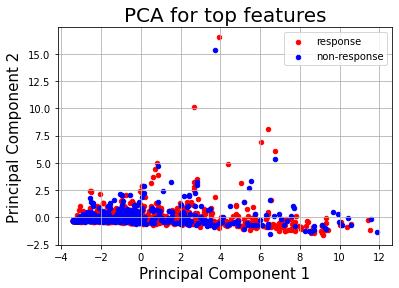

In [7]:
test_scale_normalize = plot_pca_2_components_normalize_scale(df, features, y_cat)

In [8]:
# Tree-based feature selection

def calculate_feature_impt_tree_based(df, features, y_cat):
    clf = ExtraTreesClassifier()
    clf = clf.fit(df[features], df[y_cat])
    impt = clf.feature_importances_
    #f_top1, f_top2, f_top3 = df_feature_impt['feature'].iloc[0],df_feature_impt['feature'].iloc[1],df_feature_impt['feature'].iloc[2]
    df_feature_impt = pd.DataFrame({'feature': features,'impt': impt,}).sort_values(by=['impt'],ascending=False)
    
    return df_feature_impt

In [9]:
calculate_feature_impt_tree_based(df, features, y_cat)

/Users/huangz36/anaconda3/envs/shapml/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


,feature,impt
11,BCRP,0.114429
1,MADCAM1,0.114350
2,RDW_base,0.113123
4,PLATE_base,0.108371
5,LDH_base,0.106965
10,BFECAL,0.106246
6,CREATN_base,0.101365
9,TPROT_base,0.097806
8,BMCS,0.067338
3,STOOLFN,0.042773


In [10]:
# Visualize the spearman correlation matrix
# The correlation matrix spearman computed
# Generate a mask for the upper triangle
def feature_spearman_corr_plot(df, features):
    spearman_matrics = df[features].corr(method='spearman')

    mask = np.zeros_like(spearman_matrics, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 10))

    fig = sns.heatmap(spearman_matrics, vmin=spearman_matrics.values.min(), mask = mask, vmax=1, square=True, 
            linewidths=0.1, annot=True, annot_kws={"size":10}, cmap="BuPu")
    
    return fig

/Users/huangz36/anaconda3/envs/shapml/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


<AxesSubplot:>

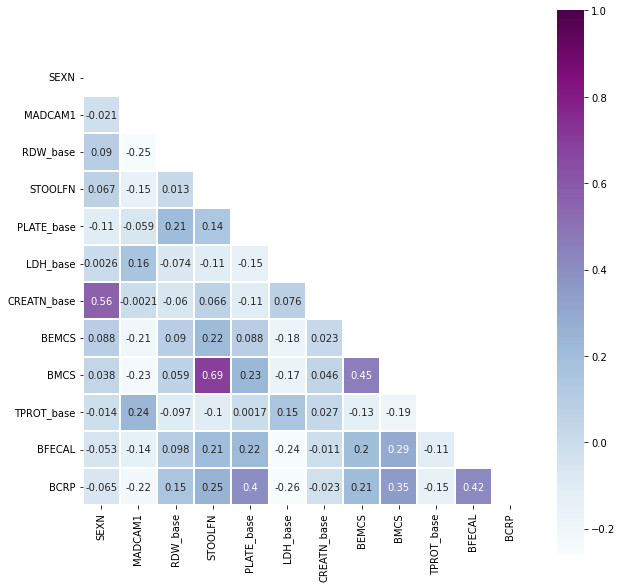

In [11]:
feature_spearman_corr_plot(df, features)

In [12]:
cat_features = ['SEXN', 'STOOLFN','BEMCS']
cont_features = ['MADCAM1', 'RDW_base', 'PLATE_base', 'LDH_base', 'CREATN_base', 'BMCS', 'TPROT_base', \
    'BFECAL', 'BCRP']

features = ['SEXN', 'MADCAM1', 'RDW_base', 'STOOLFN','PLATE_base', 'LDH_base', 'CREATN_base', 'BEMCS', 'BMCS', 'TPROT_base', \
    'BFECAL', 'BCRP']
y_cat = ['Treatment_Flag']
y_cont = ['CTR1']

### Plot contingency table for categorical data

In [23]:
def categorical_feature_contingency_table(df, cat_feature,y_cat):
    '''
    cat_feature = 'SEXN' (use string)
    y_cat = 'Treatment_Flag' (use string)
    '''

    fig = plt.figure(num=None, figsize=(4, 4), dpi=80, facecolor='w', edgecolor='k')
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    data_crosstab = pd.crosstab(df[cat_feature],df[y_cat], margins = False)
    sns.heatmap(data_crosstab, annot=True, fmt='.2f')
    if data_crosstab.shape[0] == 2:
        oddsr, p = fisher_exact(table=data_crosstab.to_numpy())
        title = "Fisher's Exact p-value: " + "{:.2f}".format(p)
        plt.title(title)

    return plt

<module 'matplotlib.pyplot' from '/Users/huangz36/anaconda3/envs/shapml/lib/python3.7/site-packages/matplotlib/pyplot.py'>

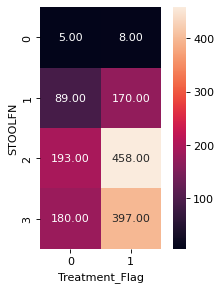

In [24]:
cat_feature = 'STOOLFN'
y_cat = 'Treatment_Flag'

categorical_feature_contingency_table(df, cat_feature,y_cat)

<module 'matplotlib.pyplot' from '/Users/huangz36/anaconda3/envs/shapml/lib/python3.7/site-packages/matplotlib/pyplot.py'>

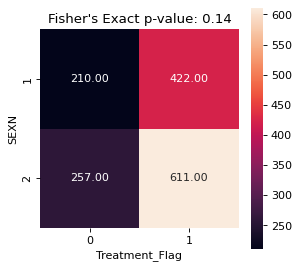

In [25]:
cat_feature = 'SEXN'
y_cat = 'Treatment_Flag'

categorical_feature_contingency_table(df, cat_feature,y_cat)

<module 'matplotlib.pyplot' from '/Users/huangz36/anaconda3/envs/shapml/lib/python3.7/site-packages/matplotlib/pyplot.py'>

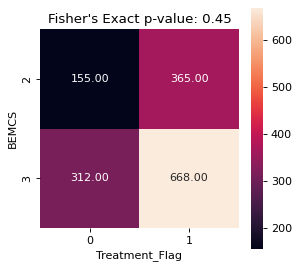

In [26]:
categorical_feature_contingency_table(df, 'BEMCS',y_cat)

### Perform wilcoxon test for continuous variable

In [27]:
def continous_feature_ranksum_test_and_plot(df, cont_var,y_cat):
    group1 = df[df[y_cat]==1][cont_var]
    group2 = df[df[y_cat]==0][cont_var]
    stat, p = ranksums(group1, group2)

    fig = plt.figure(figsize=(6, 5))
    title = cont_var + " between response groups\n" + "ranksum p-value: " + "{:.4f}".format(p)

    ax = sns.boxplot(x=y_cat, y=cont_var, data=df).set(title=title)
    ax = sns.swarmplot(x=y_cat, y=cont_var, data=df, color=".25")


    return plt

/Users/huangz36/anaconda3/envs/shapml/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/huangz36/anaconda3/envs/shapml/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 43.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<module 'matplotlib.pyplot' from '/Users/huangz36/anaconda3/envs/shapml/lib/python3.7/site-packages/matplotlib/pyplot.py'>

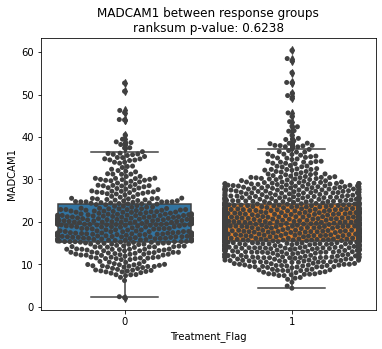

In [28]:
continous_feature_ranksum_test_and_plot(df, 'MADCAM1', y_cat)

/Users/huangz36/anaconda3/envs/shapml/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 67.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/huangz36/anaconda3/envs/shapml/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 84.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<module 'matplotlib.pyplot' from '/Users/huangz36/anaconda3/envs/shapml/lib/python3.7/site-packages/matplotlib/pyplot.py'>

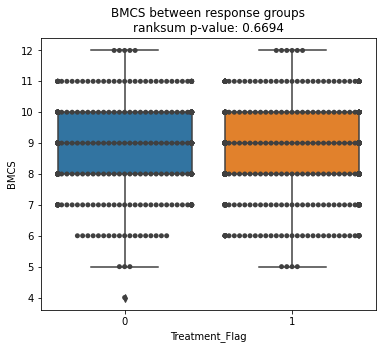

In [29]:
continous_feature_ranksum_test_and_plot(df, 'BMCS', y_cat)